Для начала подключим библиотеки, которые нам понадобятся и загрузим данные.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Посмотрим на несколько записей из набора данных
data = pd.read_csv('train.csv'  , sep=',')
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


В этом dataset'е представлена информация о выживших и погибших пассажирах Титаника:

PassengerId - Номер пассажира согласно списку; Survived - Удалось ли данному пассажиру выжить; Pclass - Класс, которым следовал пассажир; Name - Имя пассажира; Sex - Пол пассажира; Age - Возраст пассажира; SibSp - Число братьев, сестер и супругов на борту; Parch - Количество родителей и детей на борту; Ticket - Билет пассажира ; Fare - Стоимость тарифа ; Cabin - Размещение пассажира на борту; Embarked - Посадка пассажира;

Будем предсказывать значение переменной Survived, которая означает, выжил ли данный пассажир. Эта задача - задача бинарной классификации.

В нашей выборке есть признаки "PassengerId","Name", "Ticket". Очевидно, они нам не понадобятся. Выбросим их из выборки.


In [3]:
data = data.drop(['PassengerId','Name','Ticket'], axis='columns') # первый аргумент - список ненужных признаков,
                                                   # второй - поиск имен признаков по названиям колонок, а не строк

Посмотрим, можем ли мы выбросить еще какие-нибудь признаки из нашей таблицы. Это стоит делать, поскольку чем меньше признаков - тем легче вычислять расстояние между объектами, то есть алгоритм будет работать быстрее. Посмотрим на корреляцию признаков между собой. Построим графическое представление модуля значения корреляции попарно между признаками.


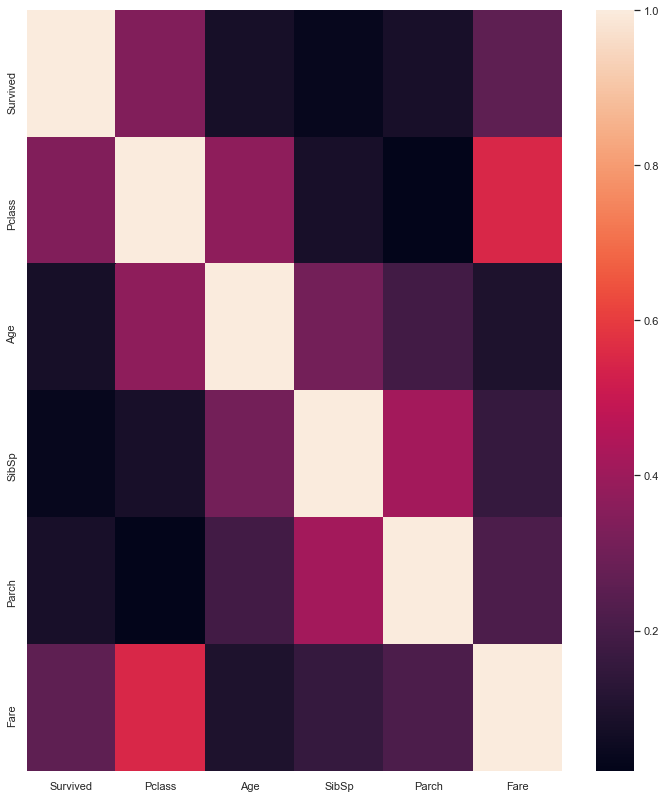

In [4]:
# Картинку отрисуем с помощью библиотеки seaborn
import seaborn as sns
# Подсчитаем корреляцию и возьмем модуль от нее
corr = data.corr().abs()
# Следующая команда устанавливает размер картинки (по умолчанию она довольно маленькая)
sns.set(rc={'figure.figsize':(12, 14)})
# Нарисуем картинку
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Другой варинат представления корреляции

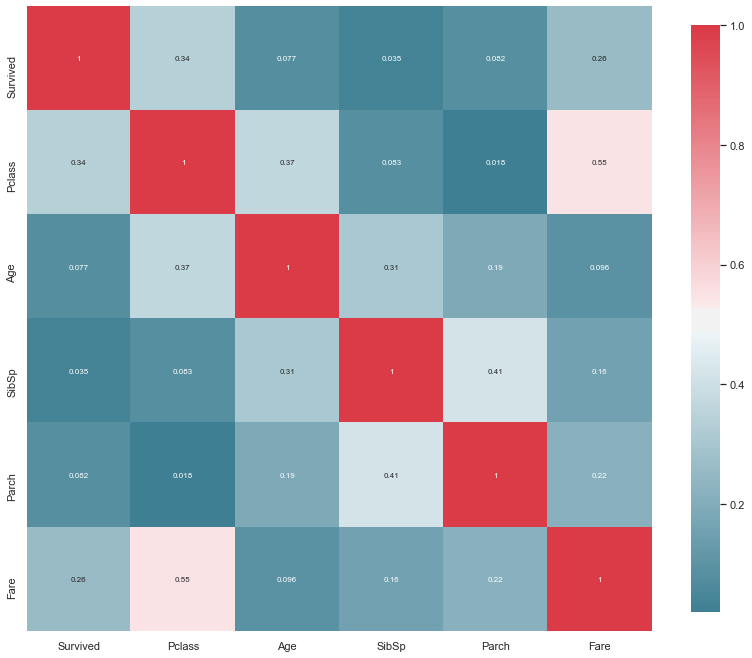

In [5]:
import seaborn as sns
def plot_correlation_map(data):
    corr=data.corr().abs()
    _ , ax=plt.subplots(figsize=(14,12))
    cmap=sns.diverging_palette(220,10,as_cmap=True)
    _=sns.heatmap(
        corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink':.9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize':8}
    )
plot_correlation_map(data)

Удалим из выборки признаки, высоко коррелирующие с другими признаками

In [6]:
data = data.drop(['Fare'], axis='columns')

В нашем dataset есть колонка с названием "Cabin", имеющая огромное число пропусков и, ставящая в соответсвие каждому пассажиру уникальное значение. Для решения задачи бинарной классификации она нам не понадобится

In [7]:
data = data.drop(['Cabin'], axis='columns')

Посокольку столбцы "SibSp" и "Parch" определяют кол-во родственников на борту для каждого пассажира, то они могут быть объединены по этому признаку. Создадим новый столбец "Member_Family"


In [8]:
data['Member_Family']=data['Parch']+data['SibSp']
data['Member_Family']=np.where(data['Member_Family']>0,1,0)
data = data.drop(['Parch','SibSp'], axis='columns')
data.dtypes

Survived           int64
Pclass             int64
Sex               object
Age              float64
Embarked          object
Member_Family      int32
dtype: object

Столбец "Sex" содержит всего два значения "male" и "female". Эти значения могут быть преобразованы в классы "1" и "0" соответственно формата int64


In [9]:
data['Sex']=np.where(data['Sex']=='male',1,data['Sex'])
data['Sex']=np.where(data['Sex']=='female',0,data['Sex'])
data['Sex']=data['Sex'].astype(np.int64)

Теперь разберемся со столбцом "Age". Заполним недостающие данные медианными значениями и преобразуем к типу int64

In [10]:
data['Age']=data['Age'].fillna(data['Age'].median())
data['Age']=data['Age'].round(0)
data['Age']=data['Age'].astype(np.int64)

Определим кол-во уникальных классов для столбца "Embarked"


In [11]:
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

Как мы можем увидеть, их всего 4: S - Southampton, C - Chebourg, Q - Queenstown. заполним недостающие фрагменты модальным значением и разобьем их на классы

In [12]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
data['S']=np.where(data['Embarked']=='S',1,0)
data['C']=np.where(data['Embarked']=='C',1,0)
data['Q']=np.where(data['Embarked']=='Q',1,0)
data=data.drop(['Embarked'],axis='columns')

In [13]:
data.dtypes

Survived         int64
Pclass           int64
Sex              int64
Age              int64
Member_Family    int32
S                int32
C                int32
Q                int32
dtype: object

In [14]:
data.isna().any()

Survived         False
Pclass           False
Sex              False
Age              False
Member_Family    False
S                False
C                False
Q                False
dtype: bool

Удалим столбец "S,Q,C" ввиду его малой корреляции с целевой функцией

In [15]:
data = data.drop(['S'], axis='columns')
data = data.drop(['C'], axis='columns')
data = data.drop(['Q'], axis='columns')

Теперь Machine Learning

Выделим в нашей выборке целевую переменную, а также разделим ее на тренировочную и тестовую. Цель построения модели - классифицировать новые данные. По умолчанию,train_test_split откладывает 25% выборок в исходном наборе данных для тестирования.

In [16]:
X = data[data.columns[1:]]
y = data['Survived']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25)

In [17]:
#количество элементов в выборках
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(668, 4)
(668,)
(223, 4)
(223,)


In [18]:
# импортируем класс классификатора по ближайшим соседям
from sklearn.neighbors import KNeighborsClassifier
# создадим наш классификатор. Гиперпараметр у этого алгоритма один - количество соседей.
clf = KNeighborsClassifier(n_neighbors=5)
# обучим классификатор на тренировочной выборке
clf.fit(X_train, y_train)
# подсчитаем долю верных ответов алгоритма на тестовой выборке.
clf.score(X_test, y_test)

0.7757847533632287

In [19]:
print(X_test)

     Pclass  Sex  Age  Member_Family
367       3    0   28              0
827       2    1    1              1
399       2    0   28              0
661       3    1   40              0
315       3    0   26              0
..      ...  ...  ...            ...
558       1    0   39              1
349       3    1   42              0
492       1    1   55              0
118       1    1   24              1
360       3    1   40              1

[223 rows x 4 columns]


In [20]:
print(y_test)

367    1
827    1
399    1
661    0
315    1
      ..
558    1
349    0
492    0
118    0
360    0
Name: Survived, Length: 223, dtype: int64


In [21]:
y_pred = clf.predict(X_test)
print(y_pred)

[0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1
 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0
 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1
 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1
 0]


Посмотрим, как влияет гиперпараметр на качество классификации.

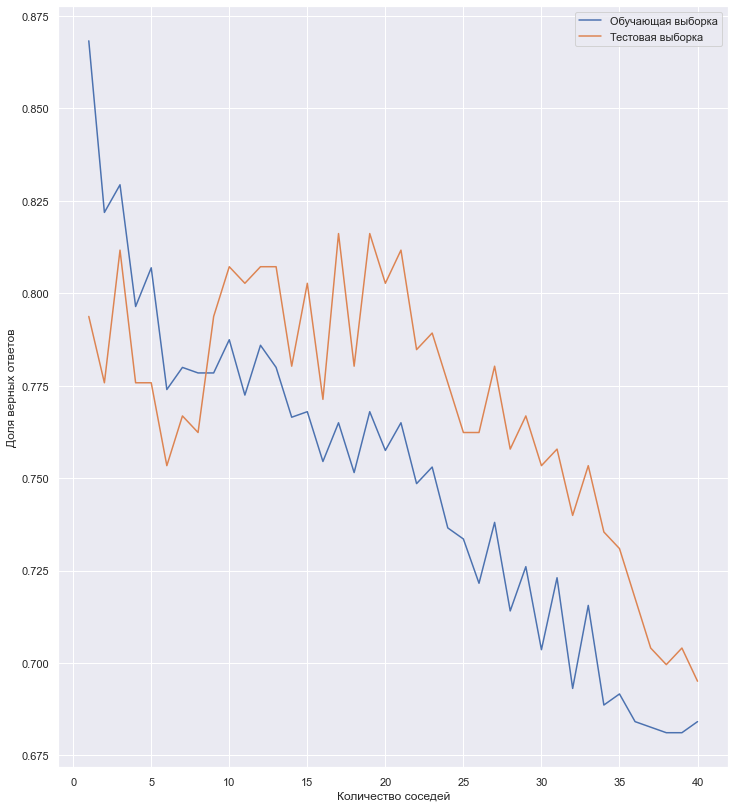

In [22]:
# Создадим пустой словарь. Будем добавлять в него значения наших "скоров". Ключами будет значение гиперпараметра,
# значениями - качество работы. Рассмотрим отдельно качество на тренировочной выборке и на тестовой.
train_scores = {}
test_scores = {}

# для n в диапазоне от 1 до 40 включительно
for n in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    current_train_score = clf.score(X_train, y_train)
    current_test_score = clf.score(X_test, y_test)
    # запишем его в наши словари
    train_scores[n] = current_train_score
    test_scores[n] = current_test_score

# нарисуем графики

plt.plot(list(train_scores.keys()), list(train_scores.values()), label='Обучающая выборка')
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Тестовая выборка')
plt.xlabel('Количество соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [23]:
data1=data

Поиск наилучшего классификатора

Посмотрим на распределения и возможные зависимости признаков.

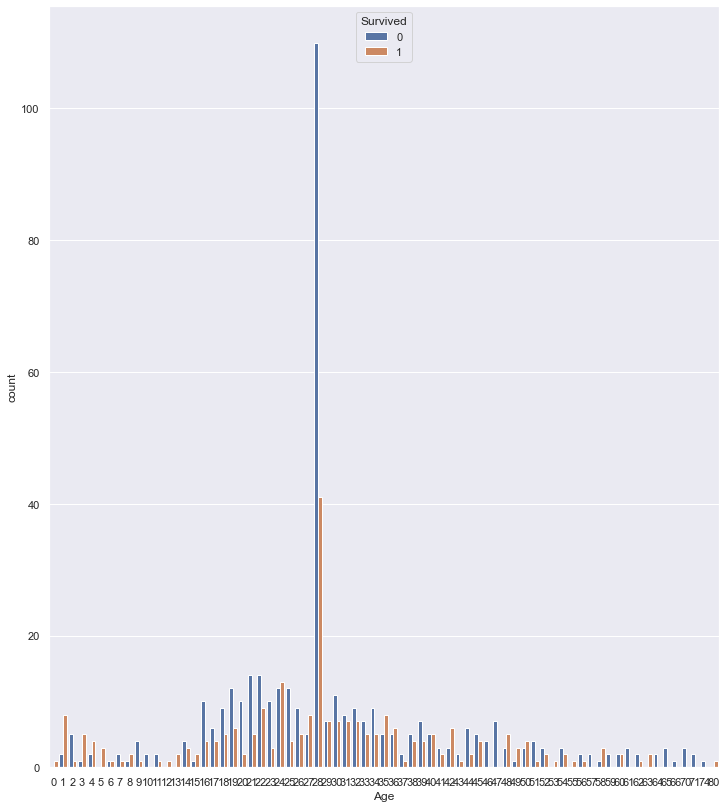

In [24]:
sns.countplot(X_train['Age'], hue=y_train)

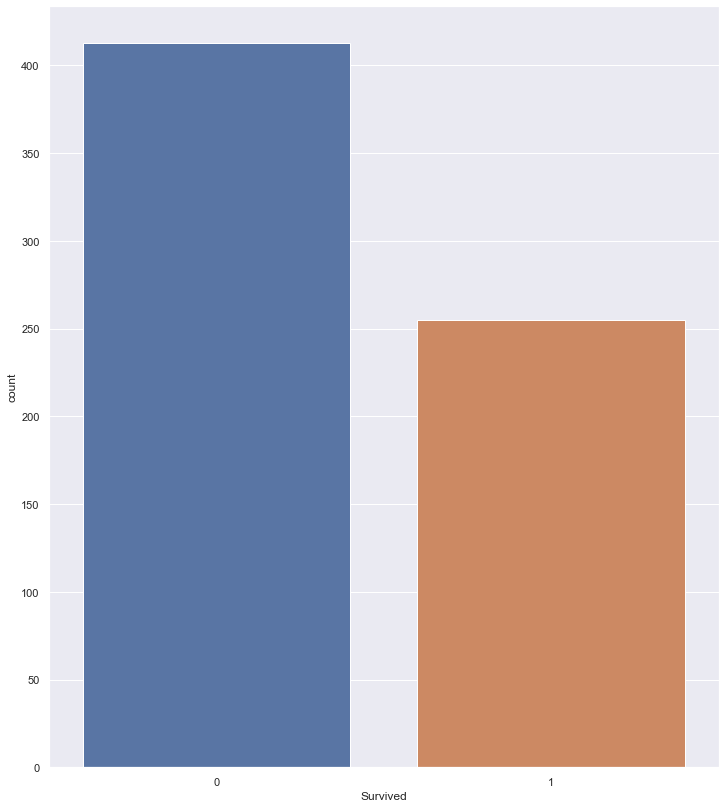

In [25]:
sns.countplot(y_train)

Видно, что выживших намного меньше чем погибших. Имеет смысл провести стратификацию 

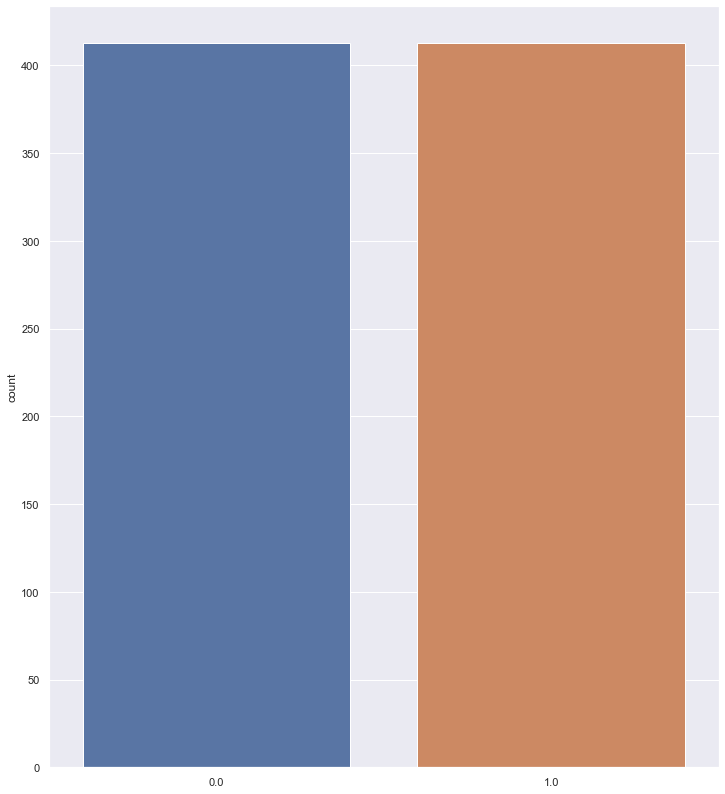

In [26]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(drop=True, inplace=True)

dead=X_train[y_train == 0]
isdead=dead[0:len(X_train[y_train == 0])-len(X_train[y_train == 1])]
X_train_start = pd.concat([X_train,isdead],ignore_index = True)
y_train_strat = pd.concat([y_train,pd.Series(np.ones(X_train_start.shape[0]-X_train.shape[0]))],
                          ignore_index=True)
                          
sns.countplot(y_train_strat)

Распределение признаков между собой

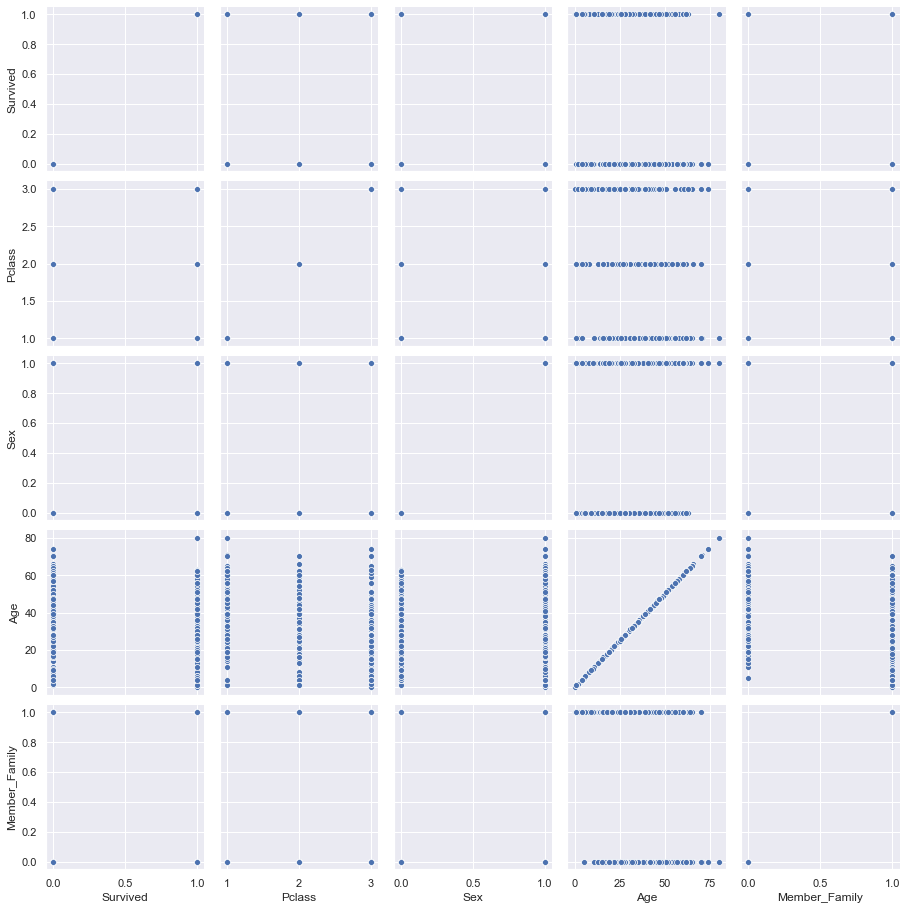

In [27]:
Titanic = sns.PairGrid(data1)
Titanic.map(sns.scatterplot)

Нормализация

Качество алгоритма до нормализации: 0.7488789237668162
Качество алгоритма после нормализации: 0.7937219730941704


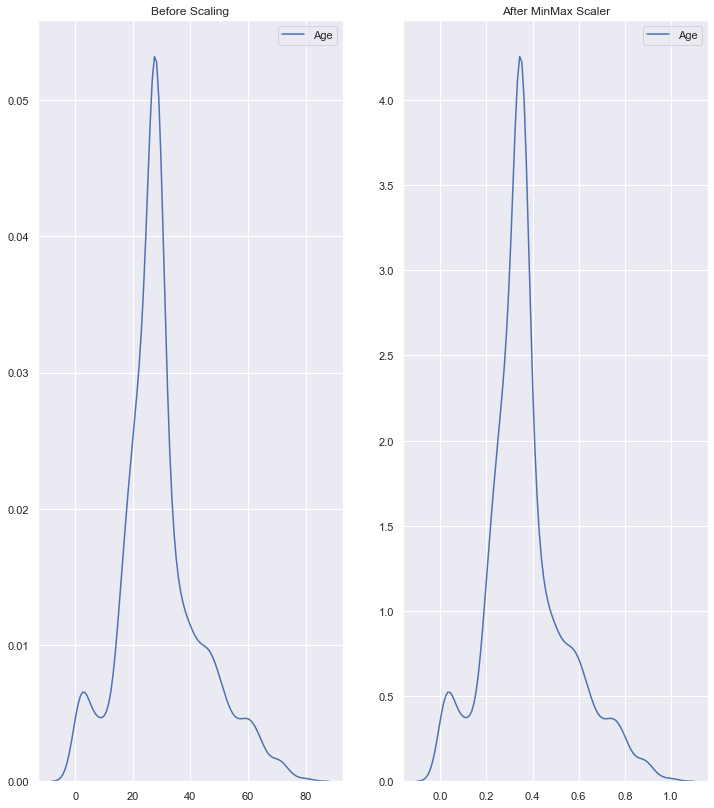

     Pclass  Sex  Age  Member_Family
0         1    0   35              1
1         2    0   24              1
2         3    1   29              0
3         1    1   71              0
4         1    1   19              1
..      ...  ...  ...            ...
821       3    1   24              1
822       1    1   28              0
823       1    1   28              0
824       3    1   47              0
825       3    1   29              1

[826 rows x 4 columns]
     Pclass  Sex     Age  Member_Family
0       0.0  0.0  0.4375            1.0
1       0.5  0.0  0.3000            1.0
2       1.0  1.0  0.3625            0.0
3       0.0  1.0  0.8875            0.0
4       0.0  1.0  0.2375            1.0
..      ...  ...     ...            ...
821     1.0  1.0  0.3000            1.0
822     0.0  1.0  0.3500            0.0
823     0.0  1.0  0.3500            0.0
824     1.0  1.0  0.5875            0.0
825     1.0  1.0  0.3625            1.0

[826 rows x 4 columns]


In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=5).fit(X_train_start, y_train_strat).score(X_test, y_test))

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_start), columns=X_train_start.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train_start.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y_train_strat).score(X_test_scaled, y_test))

# графики
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train_start['Age'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['Age'], ax=ax2)
plt.show()
print(X_train_start)
print(X_train_scaled)

Подбор алгоритма

In [29]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train_strat)
print("training accuracy :", model.score(X_train_scaled, y_train_strat))
print("testing accuracy :", model.score(X_test_scaled, y_test))

training accuracy : 0.6731234866828087
testing accuracy : 0.8026905829596412


In [30]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train_strat)
print("training accuracy :", model.score(X_train_scaled, y_train_strat))
print("testing accuracy :", model.score(X_test_scaled, y_test))

training accuracy : 0.7397094430992736
testing accuracy : 0.8071748878923767


In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_scaled, y_train_strat)
print("training accuracy :", model.score(X_train_scaled, y_train_strat))
print("testing accuracy :", model.score(X_test_scaled, y_test))

training accuracy : 0.7397094430992736
testing accuracy : 0.7757847533632287


Чтоб было интересней, выкинем коррелирующий с целевой переменной признак

In [32]:
X_train_scaled=X_train_scaled.drop(['Member_Family'], axis='columns')
X_test_scaled=X_test_scaled.drop(['Member_Family'], axis='columns')

In [33]:
for clf in [DecisionTreeClassifier(), LogisticRegression(),  RandomForestClassifier(),KNeighborsClassifier(n_neighbors=5)]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train_strat).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.8026905829596412
LogisticRegression 0.8026905829596412
RandomForestClassifier 0.7623318385650224
KNeighborsClassifier 0.8026905829596412


Метрики качества

In [34]:
from sklearn.metrics import accuracy_score
a = np.ones(y_test.shape[0])

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.3901345291479821
Precision: 0.3901345291479821
Recall: 1.0
ROC AUC: 0.5
PRC AUC: 0.695067264573991
F1: 0.5612903225806452
F0.5: 0.44433094994892747
F2: 0.7618213660245184


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


В качестве метрики для решаемой нами задачи бинарной классификации был выбран метод ROC AUC, поскольку нам важно знать насколько точны наши предсказания о судьбе пассижоров титаника по отношению ко всей выборке  